In [1]:
%matplotlib widget

from IPython import display
from base64 import b64decode
from pacti.terms.polyhedra import *
from pacti.iocontract import IoContract, Var
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib import patches
import pdb
from matplotlib.collections import PatchCollection
from contract_utils import *

varPrefixes=["t", "soc", "d", "c", "u", "r", "temp"]
epsilon = 1e-3

## Power viewpoint modeling

### CHARGING Task

Objective: charge the spacecraft battery

As described in [the qualitative impacts table](#qualitative-impacts), this function affects a single viewpoint with impacts that are linear with the duration of the task:
- Power: the battery charges proportionally to a generation rate.

Contract charging1_power:

InVars: [soc2_entry, duration_charging2]
OutVars:[soc2_exit]
A: [
  -duration_charging2 <= 0.0
  -soc2_entry <= 0.0
]
G: [
  -4.0 duration_charging2 - soc2_entry + soc2_exit <= 0.0
  3.0 duration_charging2 + soc2_entry - soc2_exit <= 0.0
  soc2_exit <= 100.0
]


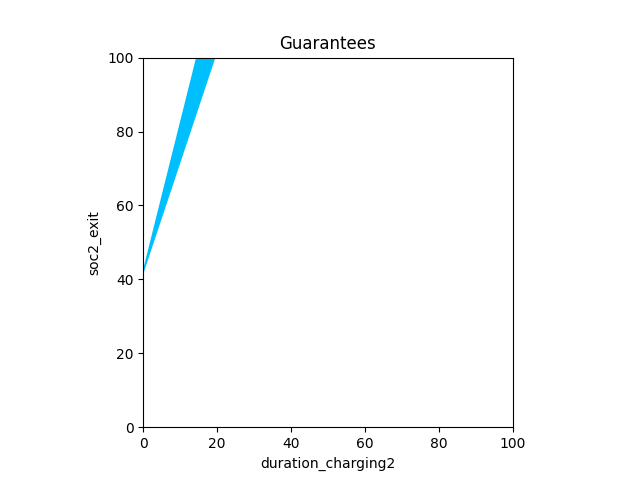

In [3]:
# Parameters:
# - s: start index of the timeline variables
# - generation: (min, max) rate of battery charge during the task instance
# - epsilon: approximately zero
def CHARGING_power(s: int, generation: tuple[float, float], epsilon: float) -> PolyhedralContract:
  spec = PolyhedralContract.from_string(
    InputVars = [
      f"soc{s}_entry",          # initial battery SOC
      f"duration_charging{s}",  # variable task duration
    ],
    OutputVars = [
      f"soc{s}_exit",           # final battery SOC
    ],
    assumptions = [
      # Task has a positive scheduled duration
      f"-duration_charging{s} <= 0",

      # Battery SOC must be positive
      f"-soc{s}_entry <= 0",
    ],
    guarantees = [
      # duration*generation(min) <= soc{exit} - soc{entry} <= duration*generation(max)
      f" soc{s}_exit - soc{s}_entry - {generation[1]}*duration_charging{s} <= 0",
      f"-soc{s}_exit + soc{s}_entry + {generation[0]}*duration_charging{s} <= 0",

      # Battery cannot exceed maximum SOC
      f"soc{s}_exit <= 100.0",
      
      # Battery should not completely discharge
      f"-soc{s}_exit <= 0",
    ])
  return spec

charging1_power = CHARGING_power(s=2, generation=(3.0, 4.0), epsilon=epsilon)
print(f"Contract charging1_power:\n\n{charging1_power}")

_ = plot_guarantees(contract=charging1_power,
                x_var=Var("duration_charging2"),
                y_var=Var("soc2_exit"),
                var_values={
                  Var("soc2_entry"):42,
                },
                x_lims=(0,100),
                y_lims=(0,100))

### DSN Task

Objective: downlink science data to Earth.

As described in [the qualitative impacts table](#qualitative-impacts), this function affects two viewpoints, each with impacts that are linear with the duration of the task:
- Power: the battery discharges proportionally to a consumption rate.
- Data: the downlinked data volume increases proportionally to a downlink speed.

Contract dsn1_power:

InVars: [soc1_entry, duration_dsn1]
OutVars:[soc1_exit]
A: [
  -duration_dsn1 <= 0.0
  4.2 duration_dsn1 - soc1_entry <= 0.0
]
G: [
  -4.2 duration_dsn1 + soc1_entry - soc1_exit <= 0.0
  3.8 duration_dsn1 - soc1_entry + soc1_exit <= 0.0
  soc1_exit <= 100.0
]


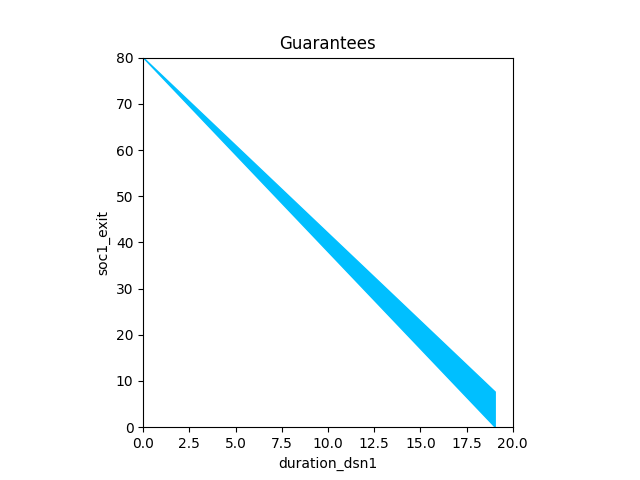

In [4]:
# Parameters:
# - s: start index of the timeline variables
# - consumption: (min, max) rate of battery discharge during the task instance
# - epsilon: approximately zero
def DSN_power(s: int, consumption: tuple[float, float], epsilon: float) -> PolyhedralContract:
  spec = PolyhedralContract.from_string(
    InputVars = [
      f"soc{s}_entry",      # initial battery SOC
      f"duration_dsn{s}",   # variable task duration
    ],
    OutputVars = [
      f"soc{s}_exit",       # final battery SOC
    ],
    assumptions = [
      # Task has a positive scheduled duration
      f"-duration_dsn{s} <= 0",

      # Battery has enough energy for worst-case consumption throughout the task instance
      f"-soc{s}_entry + {consumption[1]}*duration_dsn{s} <= 0",
    ],
    guarantees = [
      # duration*consumption(min) <= soc{entry} - soc{exit} <= duration*consumption(max)
      f" soc{s}_entry - soc{s}_exit - {consumption[1]}*duration_dsn{s} <= 0",
      f"-soc{s}_entry + soc{s}_exit + {consumption[0]}*duration_dsn{s} <= 0",

      # Battery cannot exceed maximum SOC
      f"soc{s}_exit <= 100.0",
      
      # Battery should not completely discharge
      f"-soc{s}_exit <= 0",
    ])
  return spec

dsn1_power = DSN_power(s=1, consumption=(3.8, 4.2), epsilon=epsilon)
print(f"Contract dsn1_power:\n\n{dsn1_power}")

_ = plot_guarantees(contract=dsn1_power,
                x_var=Var("duration_dsn1"),
                y_var=Var("soc1_exit"),
                var_values={
                  Var("soc1_entry"):80,
                },
                x_lims=(0,20),
                y_lims=(0,80))

### SBO Task (Small body observations)

As described in [the qualitative impacts table](#qualitative-impacts), this function affects three viewpoints, each with impacts that are linear with the duration of the task:
- Data: the science data volume grows proportionally to a generation rate.
- Power: the battery discharges proportionally to a consumption rate.
- Navigation: the trajectory estimation error decreases proportionally to an improvement rate.

Contract sbo1_power:

InVars: [soc3_entry, duration_sbo3]
OutVars:[soc3_exit]
A: [
  -duration_sbo3 <= 0.0
  1.4 duration_sbo3 - soc3_entry <= 0.0
]
G: [
  -1.4 duration_sbo3 + soc3_entry - soc3_exit <= 0.0
  duration_sbo3 - soc3_entry + soc3_exit <= 0.0
  soc3_exit <= 100.0
]


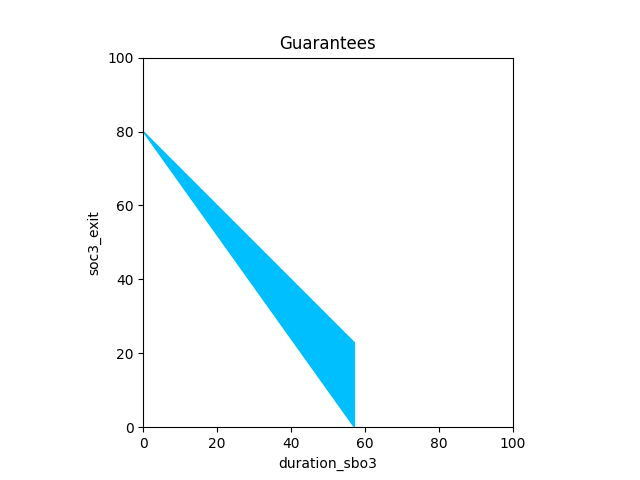

In [5]:
# Parameters:
# - s: start index of the timeline variables
# - consumption: (min, max) rate of battery discharge during the task instance
# - epsilon: approximately zero
def SBO_power(s: int, consumption: tuple[float, float], epsilon: float) -> PolyhedralContract:
  spec = PolyhedralContract.from_string(
    InputVars = [
      f"soc{s}_entry",      # initial battery SOC
      f"duration_sbo{s}",   # knob variable for SBO duration
    ],
    OutputVars = [
      f"soc{s}_exit",       # final battery SOC
    ],
    assumptions = [
      # Task has a positive scheduled duration
      f"-duration_sbo{s} <= 0",

      # Battery has enough energy for consumption for the task instance
      f"-soc{s}_entry + {consumption[1]}*duration_sbo{s} <= 0",
    ],
    guarantees = [
      # duration*consumption(min) <= soc{entry} - soc{exit} <= duration*consumption(max)
      f" soc{s}_entry - soc{s}_exit - {consumption[1]}*duration_sbo{s} <= 0",
      f"-soc{s}_entry + soc{s}_exit + {consumption[0]}*duration_sbo{s} <= 0",

      # Battery cannot exceed maximum SOC
      f"soc{s}_exit <= 100.0",
      
      # Battery should not completely discharge
      f"-soc{s}_exit <= 0",
    ])
  return spec

sbo1_power = SBO_power(s=3, consumption=(1.0, 1.4), epsilon=epsilon)
print(f"Contract sbo1_power:\n\n{sbo1_power}")

_ = plot_guarantees(contract=sbo1_power,
                x_var=Var("duration_sbo3"),
                y_var=Var("soc3_exit"),
                var_values={
                  Var("soc3_entry"):80,
                },
                x_lims=(0,100),
                y_lims=(0,100))

### TCM Task (Perform a Trajectory Correction Maneuver)

Objective: Perform a delta-V maneuver to bring the spacecraft trajectory closer to that of the small body.

As described in [the qualitative impacts table](#qualitative-impacts), this function affects three viewpoints, each with impacts that are linear with the duration of the task:
- Power & Thermal: the thrusters must be heated before firing them, thereby discharging the battery proportionally to a consumption rate.
- Navigation: The navigation trajectory improves by a delta.

Since heating the thruster must happen just before firing them, this task is modeled as the composition of two subtasks: Heating and DeltaV.

#### TCM Heating SubTask


Contract tcm1_heating_power:

InVars: [soc4_entry, duration_tcm_heating4]
OutVars:[soc4_exit]
A: [
  -duration_tcm_heating4 <= 0.0
  1.4 duration_tcm_heating4 - soc4_entry <= 0.0
]
G: [
  -1.4 duration_tcm_heating4 + soc4_entry - soc4_exit <= 0.0
  duration_tcm_heating4 - soc4_entry + soc4_exit <= 0.0
  soc4_exit <= 100.0
]


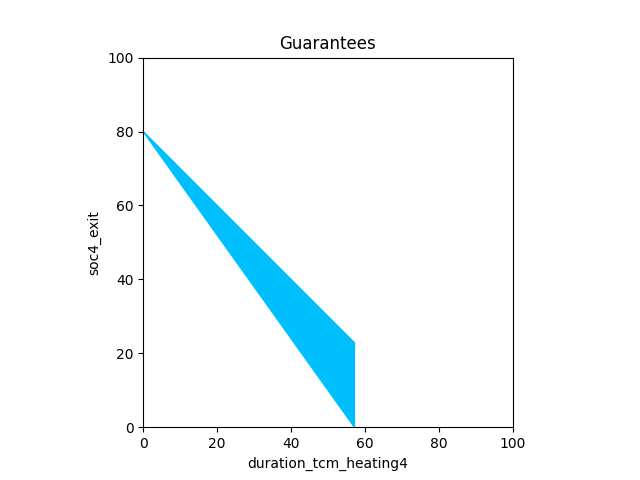

In [6]:
def TCM_heating_power(s: int, heating_cost: tuple[float, float]) -> PolyhedralContract:
  spec = PolyhedralContract.from_string(
    InputVars = [
      f"soc{s}_entry",            # initial battery SOC
      f"duration_tcm_heating{s}", # knob variable for TCM heating duration
    ],
    OutputVars = [
      f"soc{s}_exit",     # final battery SOC
    ],
    assumptions = [
      # Task has a positive scheduled duration
      f"-duration_tcm_heating{s} <= 0",

      # Battery SOC has enough to perform the heating
      f"-soc{s}_entry + {heating_cost[1]}*duration_tcm_heating{s} <= 0",
    ],
    guarantees = [
      # duration*heating_cost(min) <= soc{entry} - soc{exit} <= duration*heating_cost(max)
      f" soc{s}_entry - soc{s}_exit - {heating_cost[1]}*duration_tcm_heating{s} <= 0",
      f"-soc{s}_entry + soc{s}_exit + {heating_cost[0]}*duration_tcm_heating{s} <= 0",

      # Battery cannot exceed maximum SOC
      f"soc{s}_exit <= 100.0",
      
      # Battery should not completely discharge
      f"-soc{s}_exit <= 0",
    ])
  return spec

tcm1_heating_power = TCM_heating_power(s=4, heating_cost=(1.0, 1.4))
print(f"Contract tcm1_heating_power:\n\n{tcm1_heating_power}")

_ = plot_guarantees(contract=tcm1_heating_power,
                x_var=Var("duration_tcm_heating4"),
                y_var=Var("soc4_exit"),
                var_values={
                  Var("soc4_entry"):80,
                },
                x_lims=(0,100),
                y_lims=(0,100))

#### TCM DeltaV SubTask


Contract tcm1_deltav_power:

InVars: [soc5_entry, duration_tcm_deltav5]
OutVars:[soc5_exit]
A: [
  -duration_tcm_deltav5 <= 0.0
  0.6 duration_tcm_deltav5 - soc5_entry <= 0.0
]
G: [
  -0.6 duration_tcm_deltav5 + soc5_entry - soc5_exit <= 0.0
  0.5 duration_tcm_deltav5 - soc5_entry + soc5_exit <= 0.0
  soc5_exit <= 100.0
]


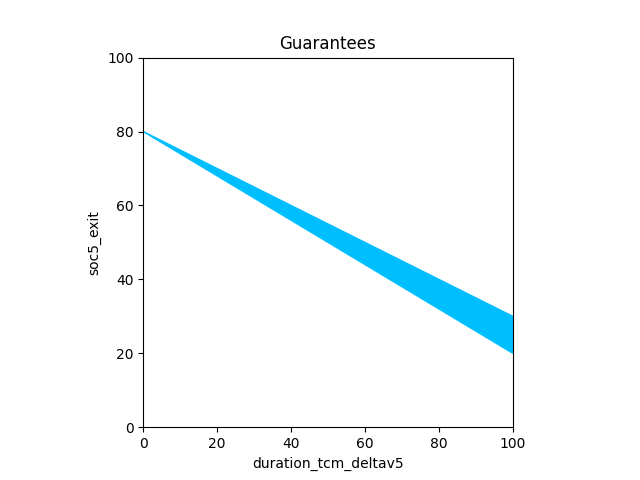

In [8]:
def TCM_deltav_power(s: int, consumption: tuple[float, float]) -> PolyhedralContract:
  spec = PolyhedralContract.from_string(
    InputVars = [
      f"soc{s}_entry",            # initial battery SOC
      f"duration_tcm_deltav{s}",  # knob variable for TCM deltav duration
    ],
    OutputVars = [
      f"soc{s}_exit",             # final battery SOC
    ],
    assumptions = [
      # Task has a positive scheduled duration
      f"-duration_tcm_deltav{s} <= 0",

      # Battery SOC has enough to perform the heating
      f"-soc{s}_entry + {consumption[1]}*duration_tcm_deltav{s} <= 0",
    ],
    guarantees = [
      # duration*consumption(min) <= soc{entry} - soc{exit} <= duration*consumption(max)
      f" soc{s}_entry - soc{s}_exit - {consumption[1]}*duration_tcm_deltav{s} <= 0",
      f"-soc{s}_entry + soc{s}_exit + {consumption[0]}*duration_tcm_deltav{s} <= 0",

      # Battery cannot exceed maximum SOC
      f"soc{s}_exit <= 100.0",
      
      # Battery should not completely discharge
      f"-soc{s}_exit <= 0",
    ])
  return spec

tcm1_deltav_power = TCM_deltav_power(s=5, consumption=(0.5, 0.6))
print(f"Contract tcm1_deltav_power:\n\n{tcm1_deltav_power}")

_ = plot_guarantees(contract=tcm1_deltav_power,
                x_var=Var("duration_tcm_deltav5"),
                y_var=Var("soc5_exit"),
                var_values={
                  Var("soc5_entry"):80,
                },
                x_lims=(0,100),
                y_lims=(0,100))

#### Composing TCM SubTasks

Algebraic composition allows us to capture the requirement that a TCM Heating subtask must always precede a TCM DeltaV subtask by composing them.

In [9]:
tcm1_deltav_power_right=tcm1_deltav_power.rename_variables([("soc5_entry", "soc4_exit")])
print(f"========= tcm1_deltav_power_right\n{tcm1_deltav_power_right}")
tcm1_power=tcm1_heating_power.compose(tcm1_deltav_power_right, vars_to_keep=["soc4_exit"]).rename_variables([("soc4_exit", "output_soc4")])
print(f"========= tcm1_power\n{tcm1_power}")
tcm1_power.get_variable_bounds("soc5_exit")

========= tcm1_deltav_power_right
InVars: [duration_tcm_deltav5, soc4_exit]
OutVars:[soc5_exit]
A: [
  -duration_tcm_deltav5 <= 0.0
  0.6 duration_tcm_deltav5 - soc4_exit <= 0.0
]
G: [
  -0.6 duration_tcm_deltav5 + soc4_exit - soc5_exit <= 0.0
  0.5 duration_tcm_deltav5 - soc4_exit + soc5_exit <= 0.0
  soc5_exit <= 100.0
]
========= tcm1_power
InVars: [soc4_entry, duration_tcm_heating4, duration_tcm_deltav5]
OutVars:[soc5_exit, output_soc4]
A: [
  -duration_tcm_deltav5 <= 0.0
  0.6 duration_tcm_deltav5 + 1.4 duration_tcm_heating4 - soc4_entry <= 0.0
  -duration_tcm_heating4 <= 0.0
]
G: [
  -1.4 duration_tcm_heating4 - output_soc4 + soc4_entry <= 0.0
  duration_tcm_heating4 + output_soc4 - soc4_entry <= 0.0
  output_soc4 <= 100.0
  -0.6 duration_tcm_deltav5 + output_soc4 - soc5_exit <= 0.0
  0.5 duration_tcm_deltav5 - output_soc4 + soc5_exit <= 0.0
]


(-1.4210854715202004e-14, 100.0)

### Power Schedule Analysis

Let's consider a simple 4-step schedule of the following sequence of task instances, which we compose:
- DSN
- CHARGING
- SBO
- TCM

In [10]:
steps12=dsn1_power.compose(charging1_power.rename_variables([("soc2_entry", "soc1_exit")]), vars_to_keep=["soc1_exit"]).rename_variables([("soc1_exit", "output_soc1")])
print(f"---- Steps 1,2\n{steps12}")
steps12.get_variable_bounds("output_soc1")

---- Steps 1,2
InVars: [soc1_entry, duration_dsn1, duration_charging2]
OutVars:[soc2_exit, output_soc1]
A: [
  -duration_charging2 <= 0.0
  -duration_dsn1 <= 0.0
  4.2 duration_dsn1 - soc1_entry <= 0.0
]
G: [
  -4.2 duration_dsn1 - output_soc1 + soc1_entry <= 0.0
  3.8 duration_dsn1 + output_soc1 - soc1_entry <= 0.0
  -4.0 duration_charging2 - output_soc1 + soc2_exit <= 0.0
  3.0 duration_charging2 + output_soc1 - soc2_exit <= 0.0
  soc2_exit <= 100.0
]


(0.0, 100.0)

In [ ]:
sbo1_power_right=sbo1_power.rename_variables([("soc3_entry", "soc2_exit")])
print(sbo1_power_right)
serializer.write_contract([steps12, sbo1_power_right], filename="steps123.json")
# steps123=steps12.compose(sbo1_power_right, vars_to_keep=["soc2_exit"]).rename_variables([("soc2_exit", "output_soc2")])
steps123=steps12.compose(sbo1_power_right)
print(f"---- Steps 1,2,3\n{steps123}")
steps123.get_variable_bounds("output_soc2")

InVars: [duration_sbo3, soc2_exit]
OutVars:[soc3_exit]
A: [
  -duration_sbo3 <= 0.0
  1.4 duration_sbo3 - soc2_exit <= 0.0
]
G: [
  -1.4 duration_sbo3 + soc2_exit - soc3_exit <= 0.0
  duration_sbo3 - soc2_exit + soc3_exit <= 0.0
  soc3_exit <= 100.0
]


IncompatibleArgsError: Could not eliminate variables ['soc2_exit']
by refining the assumptions 
[
  1.4 duration_sbo3 - soc2_exit <= 0.0
]
using guarantees 
[
  -4.2 duration_dsn1 - output_soc1 + soc1_entry <= 0.0
  3.8 duration_dsn1 + output_soc1 - soc1_entry <= 0.0
  -4.0 duration_pwr2 - output_soc1 + soc2_exit <= 0.0
  3.0 duration_pwr2 + output_soc1 - soc2_exit <= 0.0
  soc2_exit <= 100.0
]


In [ ]:
steps34_right=steps34.rename_variables([("soc3_entry", "soc2_exit")])
steps1234=steps12.compose(steps34_right, vars_to_keep=["soc2_exit"]).rename_variables([("soc2_exit", "output_soc2")])
print(f"---- Steps 1,2,3,4\n{steps1234}")
steps1234.get_variable_bounds("output_soc2")

IncompatibleArgsError: Could not eliminate variables ['soc2_exit']
by refining the assumptions 
[
  1.4 duration_sbo3 + 0.6 duration_tcm_deltav5 + 1.4 duration_tcm_heating4 - soc2_exit <= 0.0
]
using guarantees 
[
  -4.2 duration_dsn1 - output_soc1 + soc1_entry <= 0.0
  3.8 duration_dsn1 + output_soc1 - soc1_entry <= 0.0
  -4.0 duration_pwr2 - output_soc1 + soc2_exit <= 0.0
  3.0 duration_pwr2 + output_soc1 - soc2_exit <= 0.0
  soc2_exit <= 100.0
]


In [ ]:
scenario_power=steps1234.rename_variables([("soc5_exit", "output_soc5")])
print(f"scenario_power={scenario_power}")

In [ ]:
operational_constraints=PolyhedralContract.from_string(
    InputVars=[
        "soc1_entry",
        "duration_dsn1",
        "duration_pwr2",
        "duration_sbo3",
        "duration_tcm_heating4",
        "duration_tcm_deltav5",
    ],
    OutputVars=[
        "output_soc1",
        "output_soc2",
        "output_soc3",
        "output_soc4",
        "output_soc5"
    ],
    assumptions=[
        "soc1_entry=80",
        "-duration_dsn1 <= -5",
        "-duration_pwr2 <= -33",
        # "-duration_sbo3 <= -1",
        # "-duration_tcm_heating4 <= -10",
        # "-duration_tcm_deltav5 <= -10",
    ],
    guarantees=[
        # "-output_soc1 <= -10",
        # "-output_soc2 <= -10",
        # "-output_soc3 <= -10",
        # "-output_soc4 <= -10",
        # "-output_soc5 <= -10",
    ]
)
operational_scenario_power = scenario_power.merge(operational_constraints)
print(f"operational_scenario_power={operational_scenario_power}")

In [ ]:
step1_dsn_bounds = operational_scenario_power.get_variable_bounds("duration_dsn1")
print(f"step1_dsn_bounds={step1_dsn_bounds}")
step2_charging_bounds = operational_scenario_power.get_variable_bounds("duration_pwr2")
print(f"step2_charging_bounds={step2_charging_bounds}")

step3_sbo_bounds = operational_scenario_power.get_variable_bounds("duration_sbo3")
print(f"step3_sbo_bounds={step3_sbo_bounds}")

step4_tcm_heating_bounds = operational_scenario_power.get_variable_bounds("duration_tcm_heating4")
print(f"step4_tcm_heating_bounds={step4_tcm_heating_bounds}")

step5_tcm_deltav_bounds = operational_scenario_power.get_variable_bounds("duration_tcm_deltav5")
print(f"step5_tcm_deltav_bounds={step5_tcm_deltav_bounds}")
max_soc = operational_scenario_power.optimize(
    "output_soc1 + output_soc2 + output_soc3 + output_soc4 + output_soc5", 
    maximize=True)
print(f"max_soc={max_soc}")
final_soc_bounds = operational_scenario_power.get_variable_bounds("output_soc5")
print(f"final_soc_bounds={final_soc_bounds}")
min_soc = operational_scenario_power.optimize(
    # "output_soc2_exit + output_soc4_exit + output_soc3_exit + output_soc1_exit + output_soc5_exit", 
    "output_soc5", 
    maximize=False)
print(f"min_soc={min_soc}")